In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
import requests
import torch.nn as nn
import torch.optim as optim
import random
!pip install datasets

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
from nltk.tokenize import sent_tokenize, word_tokenize
from datasets import load_dataset
import nltk
nltk.download('punkt')

dataset = load_dataset('cnn_dailymail', '3.0.0', split="train[:1500]") 

train_data = dataset
val_data = load_dataset('cnn_dailymail', '3.0.0', split="validation[:500]") 
test_data = load_dataset('cnn_dailymail', '3.0.0', split="test[:500]")  

def preprocess_text(text):
    sentences = sent_tokenize(text)
    tokenized_sentences = [word_tokenize(sent) for sent in sentences]
    return tokenized_sentences

train_summaries = [example['highlights'] for example in train_data]
train_texts = [example['article'] for example in train_data]

val_summaries = [example['highlights'] for example in val_data]
val_texts = [example['article'] for example in val_data]

test_summaries = [example['highlights'] for example in test_data]
test_texts = [example['article'] for example in test_data]

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from collections import Counter
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, sequences_input, sequences_target, max_length):
        self.sequences_input = sequences_input
        self.sequences_target = sequences_target
        self.max_length = max_length

    def __len__(self):
        return len(self.sequences_input)

    def __getitem__(self, index):
        input_sequence = self.sequences_input[index]
        target_summary = self.sequences_target[index]

        input_sequence = self.pad_sequence(input_sequence, self.max_length)
        target_summary = self.pad_sequence(target_summary, self.max_length)

        input_tensor = torch.tensor(input_sequence, dtype=torch.long)
        target_tensor = torch.tensor(target_summary, dtype=torch.long)

        return input_tensor, target_tensor

    def pad_sequence(self, sequence, max_length):
        if len(sequence) < max_length:
            sequence = sequence + [0] * (max_length - len(sequence))
        else:
            sequence = sequence[:max_length]
        return sequence

def sentence_to_sequence(sentence, vocab):
    return [vocab[word] for word in sentence if word in vocab]

import nltk
from collections import Counter

vocab_input = {}
vocab_target = {}

word_counter_input = Counter(word for text in train_texts for word in nltk.word_tokenize(text))
word_counter_target = Counter(word for summary in train_summaries for word in nltk.word_tokenize(summary))

for word, count in word_counter_input.items():
    if word not in vocab_input:
        vocab_input[word] = len(vocab_input)

for word, count in word_counter_target.items():
    if word not in vocab_target:
        vocab_target[word] = len(vocab_target)

train_sequences_input = [sentence_to_sequence(word_tokenize(text), vocab_input) for text in train_texts]
val_sequences_input = [sentence_to_sequence(word_tokenize(text), vocab_input) for text in val_texts]
test_sequences_input = [sentence_to_sequence(word_tokenize(text), vocab_input) for text in test_texts]

train_sequences_target = [sentence_to_sequence(word_tokenize(summary), vocab_target) for summary in train_summaries]
val_sequences_target = [sentence_to_sequence(word_tokenize(summary), vocab_target) for summary in val_summaries]
test_sequences_target = [sentence_to_sequence(word_tokenize(summary), vocab_target) for summary in test_summaries]

max_length = 128
max_summary_length = 100

train_dataset = CustomDataset(train_sequences_input, train_sequences_target, max_length)
val_dataset = CustomDataset(val_sequences_input, val_sequences_target, max_length)
test_dataset = CustomDataset(test_sequences_input, test_sequences_target, max_length)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

class LSTMModel(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super(LSTMModel, self).__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, batch_first=True, dropout=dropout)
        self.fc_out = nn.Linear(hid_dim, input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        prediction = self.fc_out(outputs)
        return prediction

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder_input_dim = len(vocab_input)
decoder_output_dim = len(vocab_target)
embedding_dim = 100
hidden_dim = 256
num_layers = 2
dropout = 0.5

lstm_model = LSTMModel(encoder_input_dim, embedding_dim, hidden_dim, num_layers, dropout).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters())

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Epochs: 10

In [4]:
l1=[]
l2=[]
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for batch_inputs, batch_targets in dataloader:
        torch.cuda.empty_cache()
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        torch.cuda.empty_cache()
        outputs = outputs.view(-1, outputs.size(2))
        batch_targets = batch_targets.view(-1)
        loss = criterion(outputs, batch_targets)
        torch.cuda.empty_cache()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        torch.cuda.empty_cache()
    l1.append(total_loss / len(dataloader))
    return total_loss / len(dataloader)


def validate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch_inputs, batch_targets in dataloader:
            torch.cuda.empty_cache()
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            outputs = model(batch_inputs)
            torch.cuda.empty_cache()
            outputs = outputs.view(-1, outputs.size(2))
            batch_targets = batch_targets.view(-1)
            loss = criterion(outputs, batch_targets)
            total_loss += loss.item()
            torch.cuda.empty_cache()
    l2.append(total_loss / len(dataloader))
    return total_loss / len(dataloader)


num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train_model(lstm_model, train_loader, criterion, optimizer, device)
    validation_loss = validate_model(lstm_model, val_loader, criterion, device)
    torch.cuda.empty_cache()
    print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {train_loss:.4f} Validation Loss: {validation_loss:.4f}")

Epoch [1/10] Train Loss: 4.8717 Validation Loss: 2.2841
Epoch [2/10] Train Loss: 3.3873 Validation Loss: 2.2806
Epoch [3/10] Train Loss: 3.3438 Validation Loss: 2.2404
Epoch [4/10] Train Loss: 3.1910 Validation Loss: 1.9983
Epoch [5/10] Train Loss: 2.9337 Validation Loss: 1.9155
Epoch [6/10] Train Loss: 2.8546 Validation Loss: 2.0101
Epoch [7/10] Train Loss: 2.8178 Validation Loss: 2.0749
Epoch [8/10] Train Loss: 2.8022 Validation Loss: 2.0607
Epoch [9/10] Train Loss: 2.7818 Validation Loss: 2.0817
Epoch [10/10] Train Loss: 2.7682 Validation Loss: 2.0033


In [5]:
def evaluate_model(model, dataloader, device):
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch_inputs, batch_targets in dataloader:
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            outputs = model(batch_inputs)
            _, predicted = torch.max(outputs, 2)
            total_correct += (predicted == batch_targets).sum().item()
            total_samples += batch_targets.numel()

    accuracy = total_correct / total_samples
    return accuracy

accuracy = evaluate_model(lstm_model, test_loader, device)
print(f"Test Accuracy: {accuracy*100:.6f}")

Test Accuracy: 73.160938


In [6]:
def evaluate_model(model, dataloader, device):
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch_inputs, batch_targets in dataloader:
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            outputs = model(batch_inputs)
            _, predicted = torch.max(outputs, 2)
            total_correct += (predicted == batch_targets).sum().item()
            total_samples += batch_targets.numel()

    accuracy = total_correct / total_samples
    return accuracy

accuracy = evaluate_model(lstm_model, val_loader, device)
print(f"Validation Accuracy: {accuracy*100:.6f}")

Validation Accuracy: 73.717188


In [7]:
def evaluate_model(model, dataloader, device):
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch_inputs, batch_targets in dataloader:
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            outputs = model(batch_inputs)
            _, predicted = torch.max(outputs, 2)
            total_correct += (predicted == batch_targets).sum().item()
            total_samples += batch_targets.numel()

    accuracy = total_correct / total_samples
    return accuracy

accuracy = evaluate_model(lstm_model, train_loader, device)
print(f"Train Accuracy: {accuracy*100:.6f}")

Train Accuracy: 65.385937


In [8]:
import matplotlib.pyplot as plt

Text(0.5, 0.98, 'LSTM MODEL')

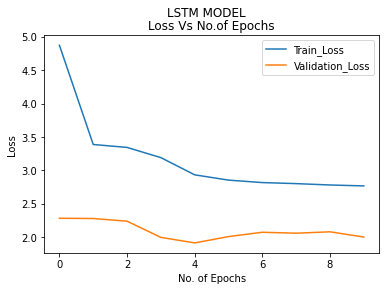

In [9]:
plt.plot(l1, label = "Train_Loss")
plt.plot(l2, label = "Validation_Loss")
plt.title("Loss Vs No.of Epochs")
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.suptitle("LSTM MODEL")

Epochs: 15

In [10]:
l3=[]
l4=[]
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for batch_inputs, batch_targets in dataloader:
        torch.cuda.empty_cache()
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        torch.cuda.empty_cache()
        outputs = outputs.view(-1, outputs.size(2))
        batch_targets = batch_targets.view(-1)
        loss = criterion(outputs, batch_targets)
        torch.cuda.empty_cache()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        torch.cuda.empty_cache()
    l3.append(total_loss / len(dataloader))
    return total_loss / len(dataloader)


def validate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch_inputs, batch_targets in dataloader:
            torch.cuda.empty_cache()
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            outputs = model(batch_inputs)
            torch.cuda.empty_cache()
            outputs = outputs.view(-1, outputs.size(2))
            batch_targets = batch_targets.view(-1)
            loss = criterion(outputs, batch_targets)
            total_loss += loss.item()
            torch.cuda.empty_cache()
    l4.append(total_loss / len(dataloader))
    return total_loss / len(dataloader)


num_epochs = 15
for epoch in range(num_epochs):
    train_loss = train_model(lstm_model, train_loader, criterion, optimizer, device)
    validation_loss = validate_model(lstm_model, val_loader, criterion, device)
    torch.cuda.empty_cache()
    print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {train_loss:.4f} Validation Loss: {validation_loss:.4f}")

Epoch [1/15] Train Loss: 2.7531 Validation Loss: 1.9774
Epoch [2/15] Train Loss: 2.7433 Validation Loss: 2.1613
Epoch [3/15] Train Loss: 2.7320 Validation Loss: 2.0539
Epoch [4/15] Train Loss: 2.7294 Validation Loss: 2.1159
Epoch [5/15] Train Loss: 2.7121 Validation Loss: 2.0926
Epoch [6/15] Train Loss: 2.6982 Validation Loss: 2.0992
Epoch [7/15] Train Loss: 2.6909 Validation Loss: 2.1676
Epoch [8/15] Train Loss: 2.6785 Validation Loss: 2.1725
Epoch [9/15] Train Loss: 2.6762 Validation Loss: 2.1749
Epoch [10/15] Train Loss: 2.6646 Validation Loss: 2.2100
Epoch [11/15] Train Loss: 2.6591 Validation Loss: 2.1763
Epoch [12/15] Train Loss: 2.6468 Validation Loss: 2.1974
Epoch [13/15] Train Loss: 2.6416 Validation Loss: 2.2953
Epoch [14/15] Train Loss: 2.6319 Validation Loss: 2.3423
Epoch [15/15] Train Loss: 2.6234 Validation Loss: 2.2664


Text(0.5, 0.98, 'LSTM MODEL')

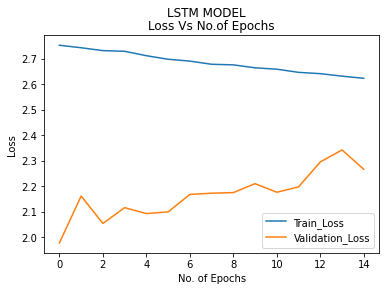

In [11]:
plt.plot(l3, label = "Train_Loss")
plt.plot(l4, label = "Validation_Loss")
plt.title("Loss Vs No.of Epochs")
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.suptitle("LSTM MODEL")

Epochs: 20

In [12]:
l5=[]
l6=[]
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for batch_inputs, batch_targets in dataloader:
        torch.cuda.empty_cache()
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        torch.cuda.empty_cache()
        outputs = outputs.view(-1, outputs.size(2))
        batch_targets = batch_targets.view(-1)
        loss = criterion(outputs, batch_targets)
        torch.cuda.empty_cache()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        torch.cuda.empty_cache()
    l5.append(total_loss / len(dataloader))
    return total_loss / len(dataloader)


def validate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch_inputs, batch_targets in dataloader:
            torch.cuda.empty_cache()
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            outputs = model(batch_inputs)
            torch.cuda.empty_cache()
            outputs = outputs.view(-1, outputs.size(2))
            batch_targets = batch_targets.view(-1)
            loss = criterion(outputs, batch_targets)
            total_loss += loss.item()
            torch.cuda.empty_cache()
    l6.append(total_loss / len(dataloader))
    return total_loss / len(dataloader)


num_epochs = 20
for epoch in range(num_epochs):
    train_loss = train_model(lstm_model, train_loader, criterion, optimizer, device)
    validation_loss = validate_model(lstm_model, val_loader, criterion, device)
    torch.cuda.empty_cache()
    print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {train_loss:.4f} Validation Loss: {validation_loss:.4f}")

Epoch [1/20] Train Loss: 2.6213 Validation Loss: 2.3246
Epoch [2/20] Train Loss: 2.6128 Validation Loss: 2.3108
Epoch [3/20] Train Loss: 2.6054 Validation Loss: 2.4274
Epoch [4/20] Train Loss: 2.5975 Validation Loss: 2.2809
Epoch [5/20] Train Loss: 2.5899 Validation Loss: 2.3954
Epoch [6/20] Train Loss: 2.5832 Validation Loss: 2.4047
Epoch [7/20] Train Loss: 2.5737 Validation Loss: 2.3194
Epoch [8/20] Train Loss: 2.5664 Validation Loss: 2.4079
Epoch [9/20] Train Loss: 2.5534 Validation Loss: 2.3625
Epoch [10/20] Train Loss: 2.5458 Validation Loss: 2.4605
Epoch [11/20] Train Loss: 2.5374 Validation Loss: 2.2239
Epoch [12/20] Train Loss: 2.5347 Validation Loss: 2.4124
Epoch [13/20] Train Loss: 2.5234 Validation Loss: 2.3669
Epoch [14/20] Train Loss: 2.5146 Validation Loss: 2.3936
Epoch [15/20] Train Loss: 2.5041 Validation Loss: 2.5074
Epoch [16/20] Train Loss: 2.4956 Validation Loss: 2.4479
Epoch [17/20] Train Loss: 2.4856 Validation Loss: 2.4593
Epoch [18/20] Train Loss: 2.4807 Validat

Text(0.5, 0.98, 'LSTM MODEL')

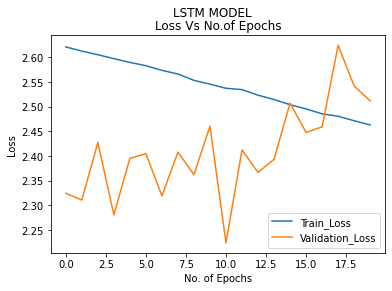

In [13]:
plt.plot(l5, label = "Train_Loss")
plt.plot(l6, label = "Validation_Loss")
plt.title("Loss Vs No.of Epochs")
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.suptitle("LSTM MODEL")

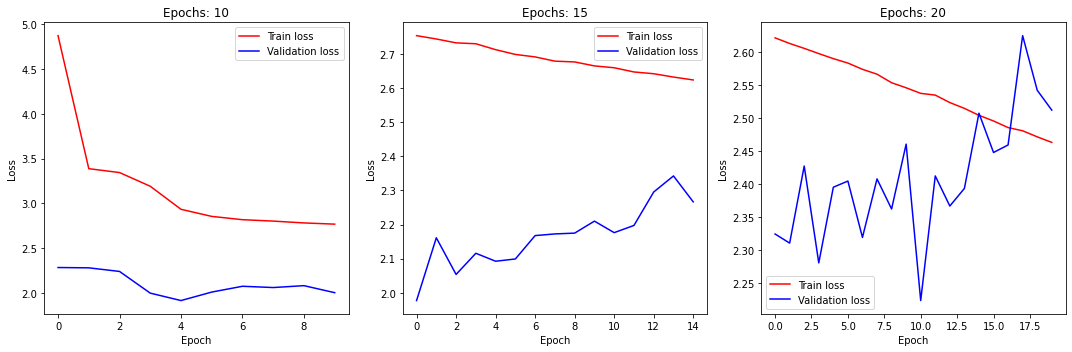

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(l1, label='Train loss', color='red')
axes[0].plot(l2, label='Validation loss', color='blue')
axes[0].set_title('Epochs: 10')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(l3, label='Train loss', color='red')
axes[1].plot(l4, label='Validation loss', color='blue')
axes[1].set_title('Epochs: 15')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

axes[2].plot(l5, label='Train loss', color='red')
axes[2].plot(l6, label='Validation loss', color='blue')
axes[2].set_title('Epochs: 20')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].legend()

plt.tight_layout()

plt.show()